# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import detect_sources
from scipy import stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from astroquery.gaia import Gaia
import pandas as pd
import subprocess
import shutil
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from pathlib import Path
from scipy.stats import siegelslopes

# Load files

In [2]:
# Loading the folders that contain the fits files
init_path = "/mnt/c/Users/catal/Downloads/Unistellar_obs/" 
scan = os.scandir(init_path)
folders = [f.path for f in scan if f.is_dir()]
folders.sort()
folders

['/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations10',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations2',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations3',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations4',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations5',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations6',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations7',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations8',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations9']

In [3]:
# Loading the fits files from the first folder inside the observations1 folder

for folder in folders:
    scan = os.scandir(folder)
    files = [f.path for f in scan if f.is_file() and f.name.endswith('.fits')]
    files.sort()
    break
files

['/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221409_165_Occultation.fits',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221410_165_Occultation.fits',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221411_166_Occultation.fits',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221412_166_Occultation.fits',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221413_166_Occultation.fits',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221414_166_Occultation.fits',
 '/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221415_166_Occultation.fits']

In [4]:
# Opening the first fits file and displaying its info
hdul = fits.open(files[0])
hdul.info()

Filename: /mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations1/20250809T221409_165_Occultation.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   (1304, 976)   int16 (rescales to uint16)   


In [5]:
# Extracting the header and data from the fits file
header = hdul[0].header
fits_data = hdul[0].data

In [6]:
# Displaying the header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1304 / length of data axis 1                          
NAXIS2  =                  976 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'ADU     '                                                            
ORIGIN  = 'Unistellar'         / institution responsible for creating this file 
DATE    = '2025-08-10T15:57:10.294' / date of file creation                     
TIMSYER =                  0.2 / systematic error on time, in TIMEUNIT          
TELESCOP= 'eVscope v1.0'    

In [7]:
# Extracting specific header information that is useful for our analysis
bais = header['BIASLVL']
exptime = header['EXPTIME']
gain = header['GAIN']
obs_time = Time(header["DATE-OBS"], format="isot", scale="utc")
location = EarthLocation(
    lat=header["LATITUDE"] * u.deg,
    lon=header["LONGITUD"] * u.deg,
    height=header.get("ALTITUDE", 0) * u.m
)
print(f"Bias level: {bais}, Exposure time: {exptime}, Gain: {gain}")
location

Bias level: 2400, Exposure time: 0.999999, Gain: 0.09076881


<EarthLocation (3950559.50442126, 502110.46509336, 4965633.1042234) m>

## Bias substraction

In [8]:
# Subtracting the bias level from the fits data
fits_data -= bais

# Image plotting

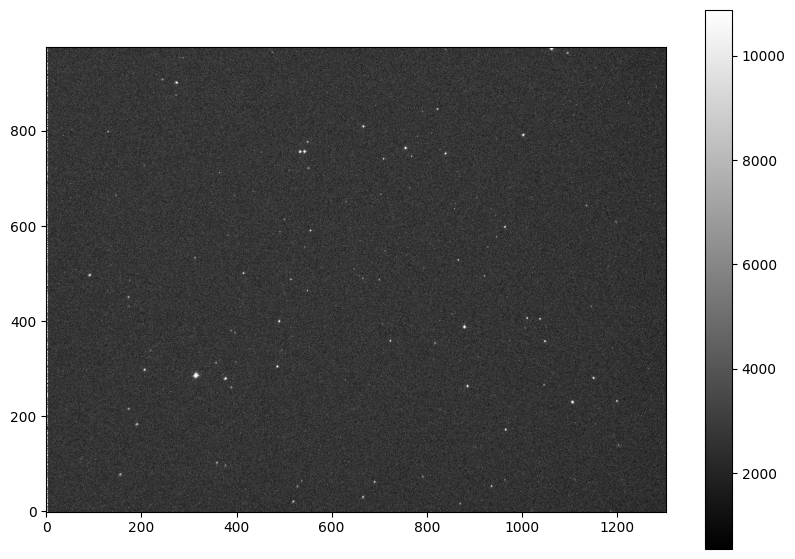

In [9]:
plt.figure(figsize=(10, 7))
norm = simple_norm(fits_data, 'linear', percent=99.5)
cb = plt.imshow(fits_data, cmap='gray', norm=norm, origin='lower')
plt.colorbar(cb)
plt.show()

## Statistics

In [10]:
np.mean(fits_data), np.median(fits_data), np.std(fits_data)

(np.float64(2848.5502481331087),
 np.float64(2672.0),
 np.float64(3060.4546428213816))

# Background estimation

In [11]:
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
threshold = detect_threshold(fits_data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(fits_data, threshold, npixels=5)
footprint = circular_footprint(radius=15)
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(fits_data, sigma=3.0, mask=mask)
mode = 3 * median - 2 * mean
print(f"Mean: {mean:.3f}, Median: {median:.3f}, Std: {std:.3f}, Mode: {mode:.3f} in ADU")

Mean: 2692.999, Median: 2656.000, Std: 852.377, Mode: 2582.002 in ADU


## Background mask plotted

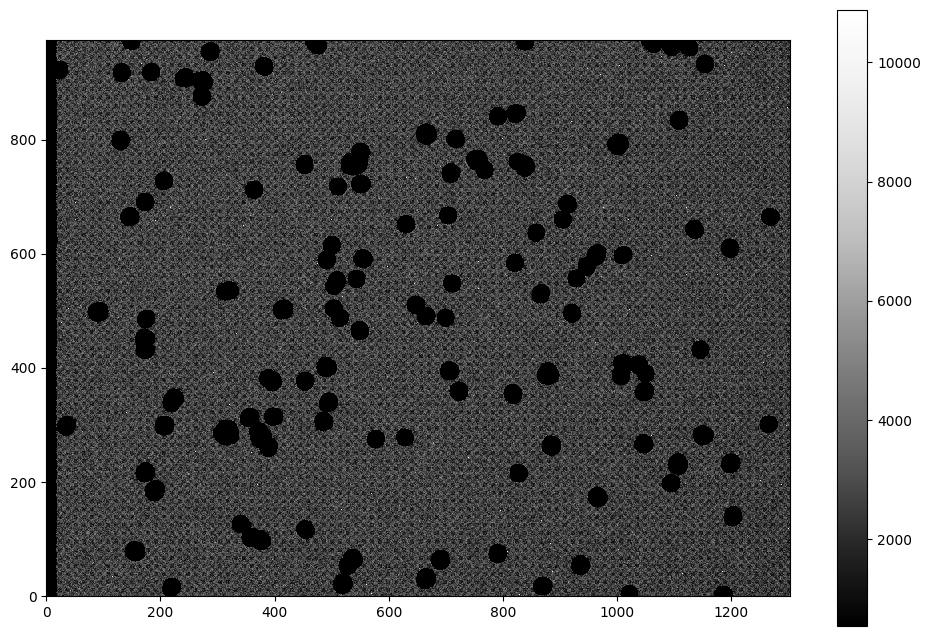

In [12]:
norm = simple_norm(fits_data, 'linear', percent=99.5)
plt.figure(figsize=(12, 8))
cb = plt.imshow(fits_data * ~mask, origin='lower', cmap='Greys_r', interpolation='nearest', norm=norm)
plt.colorbar(cb)
plt.show()

In [13]:
# fits_reduced = fits_data[~mask]
# fits_reduced.shape

In [14]:
# cond = (fits_reduced - median) < 5*std
# fits_reduced = fits_reduced[cond]

In [15]:
# mode = 3*median - 2*mean
# mode

# Data histogram

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_365303/3796101439.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(3*median-2*mean, color='purple', linestyle='dotted', linewidth=1, label=f'Mode {mode:.1f}$\pm$ {std:.1f}')


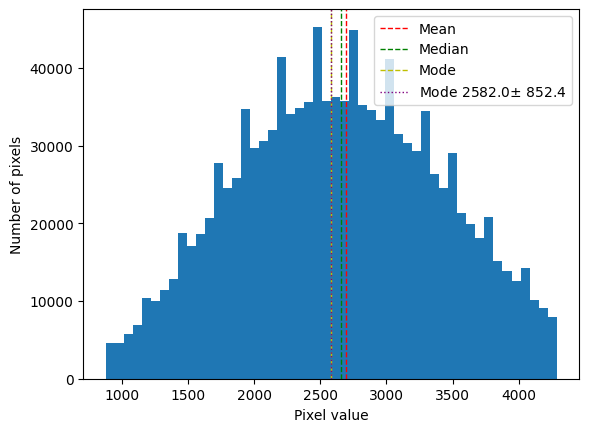

In [16]:
plt.hist(fits_data.flatten(), bins=50, range=(mode - 2*std, mode + 2*std))
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median, color='g', linestyle='dashed', linewidth=1, label='Median')
plt.axvline(mode, color='y', linestyle='dashed', linewidth=1, label='Mode')
plt.axvline(3*median-2*mean, color='purple', linestyle='dotted', linewidth=1, label=f'Mode {mode:.1f}$\pm$ {std:.1f}')
# plt.yscale('log')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.legend()
plt.show()

## Segmentation map

In [17]:
# Segmenting sources in the image
# segment_map = detect_sources(fits_data, threshold, npixels=10)
# print(segment_map)

In [18]:
# norm = ImageNormalize(stretch=SqrtStretch())
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
# ax1.imshow(fits_data, origin='lower', cmap='Greys_r', norm=norm)
# ax1.set_title('Background-subtracted Data')
# ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
# ax2.set_title('Segmentation Image')
# plt.show()

# Astrometry.net WCS implementation

In [16]:
fits_file = "/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations9/20250809T212753_188/20250809T212803_472_Occultation.fits"
outdir = "astrometry_output"

Path(outdir).mkdir(exist_ok=True)

cmd = [
   "/usr/bin/solve-field",
    fits_file,
    "--dir", outdir,
    "--overwrite",
    "--no-plots",
    "--downsample", "2",
]

subprocess.run(cmd, check=True)

Reading input file 1 of 1: "/mnt/c/Users/catal/Downloads/Unistellar_obs/unistellar_observations9/20250809T212753_188/20250809T212803_472_Occultation.fits"...
Extracting sources...
Downsampling by 2...
simplexy: found 635 sources.
Solving...
Reading file "astrometry_output/20250809T212803_472_Occultation.axy"...
Field 1 did not solve (index index-4112.fits, field objects 1-10).
Field 1 did not solve (index index-4111.fits, field objects 1-10).


KeyboardInterrupt: 

In [19]:
result = subprocess.run(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

# Expected output filenames
base = fits_file.stem
solved_marker = outdir / f"{base}.solved"
new_fits = outdir / f"{base}.new"

if not solved_marker.exists():
    print(" Astrometric solution failed: the image could not be solved.")
    # Optional: print astrometry.net output for debugging
    # print(result.stdout)
    # print(result.stderr)

else:
    print("✅ Astrometric solution successful.")

    # Define new filename
    renamed_fits = outdir / f"{base}_solved.fits"

    # Rename/move the solved FITS file
    shutil.move(new_fits, renamed_fits)

    print(f"📁 Solved image saved as: {renamed_fits}")

KeyboardInterrupt: 

# Upload of the WCS image

In [19]:
fits_file = "/mnt/c/Users/catal/Downloads/new-image.fits"

# Open the FITS file
with fits.open(fits_file) as hdul:
    data_wcs = hdul[0].data  - 2400 # usually the image is in the primary HDU

header = hdul[0].header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1304 / length of data axis 1                          
NAXIS2  =                  976 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'ADU     '                                                            
ORIGIN  = 'Unistellar'         / institution responsible for creating this file 
DATE    = '2025-08-10T15:57:10.294' / date of file creation                     
TIMSYER =                  0.2 / systematic error on time, in TIMEUNIT          
TELESCOP= 'eVscope v1.0'    

## Plot to check if the new image is good

In [20]:
# plt.figure()
# plt.imshow(data_wcs, origin="lower", cmap="gray")
# plt.colorbar(label="Intensity")
# plt.title("FITS Image")
# plt.xlabel("X pixel")
# plt.ylabel("Y pixel")
# plt.show()

 ## Statistics of new image

In [21]:
print(f"Unprocessed image: Mean: {mean:.3f}, Median: {median:.3f}, Std: {std:.3f}, Mode: {mode:.3f} in ADU")
mean, median, std = sigma_clipped_stats(data_wcs, sigma=3.0)
mode = 3*median - 2*mean
print(f"WCS image:Mean: {mean}, Median: {median}, Std: {std}, Mode: {mode}")

Unprocessed image: Mean: 2692.999, Median: 2656.000, Std: 852.377, Mode: 2582.002 in ADU
WCS image:Mean: 2696.3150337978177, Median: 2672.0, Std: 856.2168964051906, Mode: 2623.3699324043646


## Use of DAOstars to find the stars inside new image coordinates

In [22]:
wcs = WCS(header)

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
sources = daofind(data_wcs - mode)

x = sources["xcentroid"]
y = sources["ycentroid"]

ra, dec = wcs.all_pix2world(x, y, 0)

image_coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")

## Plot to check the matched centroids

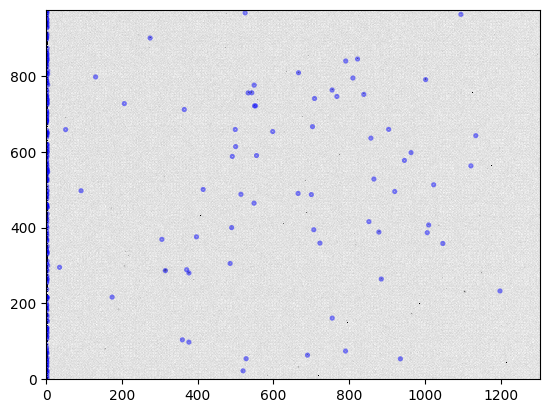

In [23]:
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data_wcs, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [24]:
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection=wcs)
# ax.imshow(data_wcs, origin='lower', cmap='gray', norm=norm)
# ax.set_xlabel('Right Ascension (J2000)')
# ax.set_ylabel('Declination (J2000)')
# ax.set_title('FITS Image with WCS')
# ax.grid(color='white', ls='dotted')
# plt.show()

# Gaia crossmatch

In [34]:
ny, nx = data_wcs.shape
center = wcs.pixel_to_world(nx/2, ny/2)

# Querying Gaia catalog around the center of the image
radius = 0.3 * u.deg
file_name = f"{os.path.basename(fits_file).split('.')[0]}_gaia_query.csv"
Gaia.ROW_LIMIT = 10000

if os.path.exists(file_name):
    df_gaia = pd.read_csv(file_name)
    from astropy.table import Table
    gaia_table = Table.from_pandas(df_gaia)
else:
    job = Gaia.cone_search_async(coordinate=center, radius=radius, columns=['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'bp_rp'])
    gaia_table = job.get_results()
    print(f"Number of Gaia sources found: {len(gaia_table)}")
    gaia_table.write(file_name, format='csv', overwrite=True)

df_gaia = gaia_table.to_pandas()

In [40]:
gaia_table.to_pandas()


,source_id,ra,dec,phot_g_mean_mag,bp_rp,dist
0,392778989764855040,3.787611,48.606691,20.714861,2.155220,0.002150
1,392779054188699776,3.781355,48.608529,19.825163,1.802074,0.003901
2,392778951108927360,3.781692,48.599520,12.799022,1.789326,0.006305
3,392779024125456640,3.775494,48.600000,16.180389,1.068991,0.008297
4,392778955405275392,3.789587,48.597333,20.931475,1.484844,0.008667
...,...,...,...,...,...,...
7209,392767788489817600,3.787130,48.305550,20.898001,1.311165,0.299896
7210,392785445100248320,3.368906,48.486805,20.559820,1.239458,0.299901
7211,392880037458812928,3.988156,48.873795,20.707104,1.184589,0.299948
7212,392725422933712000,4.096551,48.387868,16.478350,1.226091,0.299952


In [43]:
gaia_coords = SkyCoord(ra=gaia_table['ra']*u.deg, dec=gaia_table['dec']*u.deg, frame='icrs')

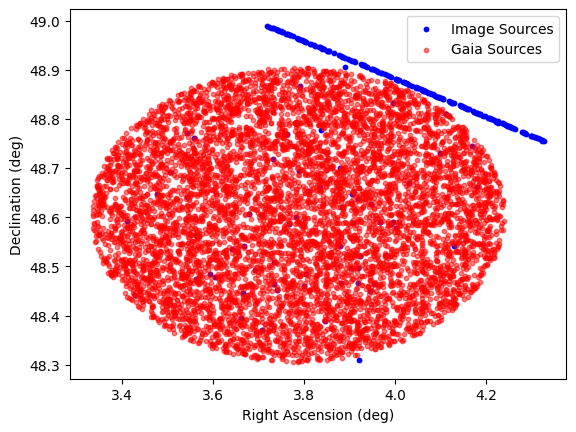

In [44]:
plt.scatter(image_coords.ra, image_coords.dec, s=10, color='blue', label='Image Sources')
plt.scatter(gaia_coords.ra, gaia_coords.dec, s=10, color='red', alpha=0.5, label='Gaia Sources')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.legend()
plt.show()

In [45]:
#gaia_coords = SkyCoord(
#    ra=gaia_table["ra"],
#    dec=gaia_table["dec"]
#)

idx, sep2d, _ = image_coords.match_to_catalog_sky(gaia_coords)

#  matching radius
max_sep = 2 * u.arcsec
matched = sep2d < max_sep

In [46]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2.15262795177888,1.5413683647585272,0.5150166058508333,0.8958338622669371,0.4215811455252983,25,62848.63006759564,555993.4510139346,-14.362674190262423,-2.795678854778607
2,1.6701619544908513,7.782937764567368,0.44900072643093975,0.42942677195504103,-0.16924858414756322,25,62656.63006759564,548287.751689891,-14.347521360500659,-2.773459999771175
3,2.2310717010267274,15.223346742213717,0.7144895197754086,0.2732846302716837,0.016755030636959153,25,62672.63006759564,680409.4510139346,-14.581925843534066,-2.4392300515773844
4,1.9966320617610744,21.156035690117648,0.3235125978064275,-0.48804409533604165,0.5672887983469683,25,62688.63006759564,993951.751689891,-14.993413258570229,-2.70533235557071
5,1.3160988110081844,21.924725826537237,0.7205751891706138,0.07969232155867978,0.9667758279024643,25,62784.63006759564,744697.4510139346,-14.679949668304955,-2.263388805347065
6,519.5984005622714,21.816458800484146,0.8483070235796821,0.14110329467880953,0.2453606213869113,25,13440.630067595635,85807.75168989088,-12.333816307153189,-0.7699257481809006
7,1.013852703315589,31.975439654048575,0.24689574564776498,-0.6140549605202292,-0.16433132639920633,25,62752.63006759564,930239.751689891,-14.921487235408893,-3.0024728591821663
8,1.3374826318614568,34.74985818568694,0.7722612582083399,-0.19898129015336935,0.6133622709907708,25,62784.63006759564,617727.751689891,-14.47699278161463,-2.501548747687574
9,0.8830201242903684,40.60724639419732,0.5129884626223341,0.4226563815892618,-0.260923803870245,25,62800.63006759564,679359.751689891,-14.580249534371667,-2.7992171962330996


In [ ]:
df_gaia = gaia_table.to_pandas().iloc[idx[matched]].reset_index(drop=True)

df_image = pd.DataFrame({
    'xcentroid': sources['xcentroid'][matched],
    'ycentroid': sources['ycentroid'][matched],
    'flux': sources['flux'][matched],
    'mag': sources['mag'][matched],
    'ra': image_coords.ra.degree[matched],
    'dec': image_coords.dec.degree[matched],
})

## Plot of cross-matched stars

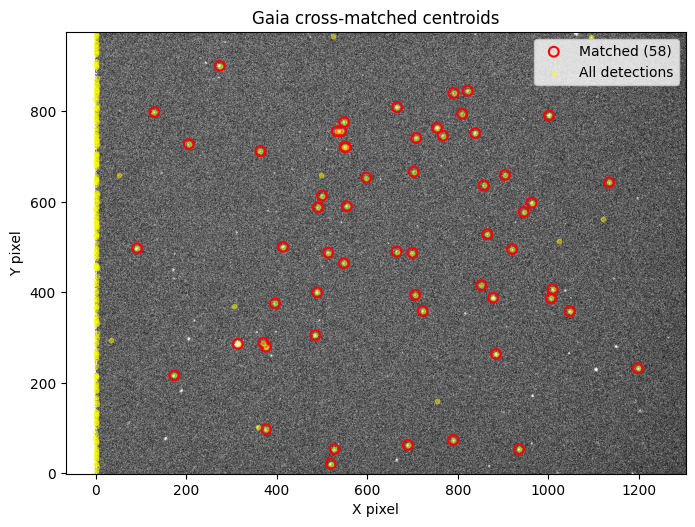

In [48]:
plt.figure(figsize=(8, 8))

vmin, vmax = np.percentile(data_wcs, [5, 99])
plt.imshow(data_wcs, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)

# matched centroids
plt.scatter(x[matched], y[matched], s=50, edgecolors="red", facecolors="none", linewidths=1.5, label=f"Matched ({matched.sum()})")

# all centroids (for reference)
plt.scatter(x, y, s=10, color="yellow", alpha=0.4, label="All detections" )

plt.legend()
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.title("Gaia cross-matched centroids")
plt.show()


# Plot and fit of gaia stars magnitude and our stars magnitude

1.1590796932177874 26.25581969013356


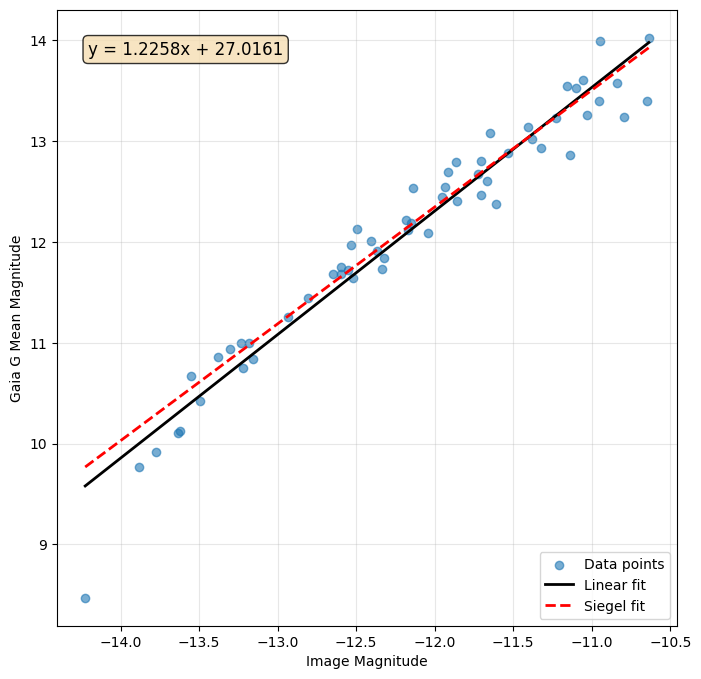

In [49]:
plt.figure(figsize=(8, 8))

# Scatter plot
plt.scatter(df_image['mag'], df_gaia['phot_g_mean_mag'], alpha=0.6, label='Data points')

# Fit linear function
coeffs = np.polyfit(df_image['mag'], df_gaia['phot_g_mean_mag'], 1)
m, b = coeffs
x_line = np.array([df_image['mag'].min(), df_image['mag'].max()])
y_line = m * x_line + b

slope, intercept = siegelslopes(df_gaia['phot_g_mean_mag'], df_image['mag'])
print(slope, intercept)

# Plot fitted line
plt.plot(x_line, y_line, 'k-', linewidth=2, label=f'Linear fit')
plt.plot(x_line, slope * x_line + intercept, 'r--', linewidth=2, label='Siegel fit')

# Add equation to the plot
equation_text = f'y = {m:.4f}x + {b:.4f}'
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.annotate(f"y = {slope:.3f}x + {intercept:.3f}", (0.5, 0.8))

plt.xlabel('Image Magnitude')
plt.ylabel('Gaia G Mean Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# First-approach calculation of background magnitude

In [50]:
bgr_mag =  -2.5*np.log10(mode)
mag_std = (2.5 / np.log(10)) * (std / mode)
bgr_mag, mag_std

(np.float64(-8.547148841490865), np.float64(0.354363169322726))

In [51]:
g_bgr =slope * bgr_mag + intercept
print(f"Background magnitude in Gaia G band: {float(g_bgr):.3f} ± {float(mag_std):.3f}")

Background magnitude in Gaia G band: 16.349 ± 0.354


# Air mass calculation 


In [52]:
altaz_frame = AltAz(obstime=obs_time, location=location)
altaz = gaia_coords.transform_to(altaz_frame)

altitude_deg = altaz.alt.deg
airmass = altaz.secz   # = 1 / cos(z)
len(altitude_deg), len(airmass)
# print(f"Altitude: {np.mean(altitude_deg):.2f}, Airmass: {np.mean(airmass):.2f}")

(7214, 7214)

# From theory

$$m+2.5\log{\left(\frac{F\times g}{t}\right)}=k \chi +Z_p$$

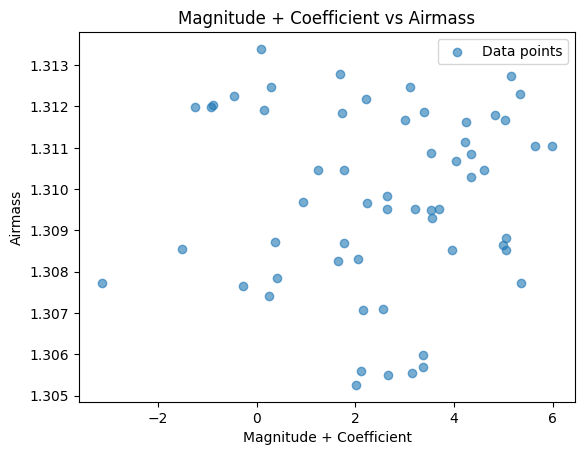

In [57]:
magnitude = df_gaia['phot_g_mean_mag']
coefficient = -2.5*np.log10((gain*df_image['flux']) / exptime)

matched_airmass = airmass[idx[matched]]
len(magnitude), len(coefficient)
plt.scatter(magnitude + coefficient, matched_airmass, alpha=0.6, label='Data points')
plt.xlabel('Magnitude + Coefficient')
plt.ylabel('Airmass')
plt.title('Magnitude + Coefficient vs Airmass')
plt.legend()
plt.show()

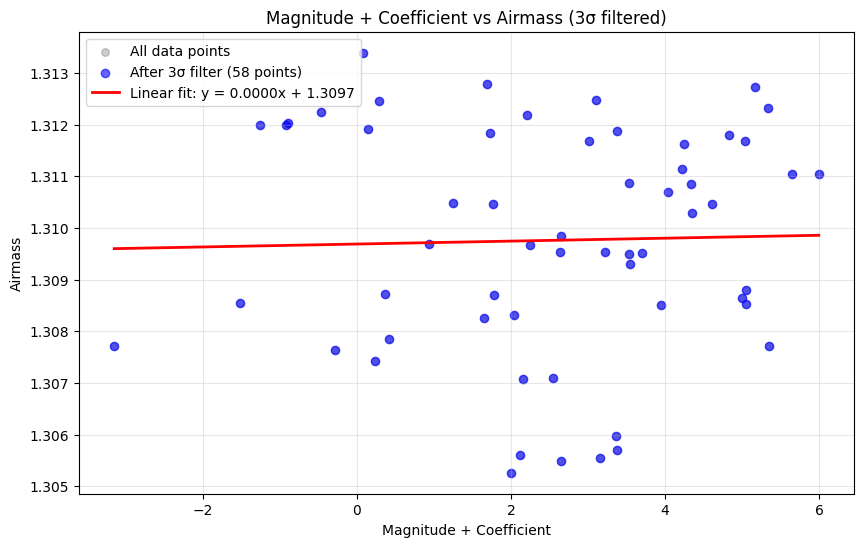

Removed 0 outliers
k (extinction coefficient) = 0.0000
Zp (zero point) = 1.3097


In [ ]:
magnitude = df_gaia['phot_g_mean_mag']
coefficient = -2.5*np.log10((gain*df_image['flux']) / exptime)

matched_airmass = airmass[idx[matched]]

# Combine data for analysis
x_data = magnitude.values + coefficient  # Extract numpy values from magnitude
y_data = matched_airmass.value  # Extract value from Quantity

# Remove 3-sigma outliers
mean_y = np.mean(y_data)
std_y = np.std(y_data)
valid = np.abs(y_data - mean_y) < 3 * std_y

x_clean = x_data[valid]
y_clean = y_data[valid]

# Fit linear function
coeffs = np.polyfit(x_clean, y_clean, 1)
k, zp = coeffs
x_line = np.array([x_clean.min(), x_clean.max()])
y_line = k * x_line + zp

# Plot
plt.figure(figsize=(10, 6))
# plt.scatter(x_data, y_data, alpha=0.4, color='gray', label='All data points', s=30)
plt.scatter(x_clean, y_clean, alpha=0.6, color='blue', label=f'After 3σ filter ({len(x_clean)} points)')
plt.plot(x_line, y_line, 'r-', linewidth=2, label=f'Linear fit: y = {k:.4f}x + {zp:.4f}')

plt.xlabel('Magnitude + Coefficient')
plt.ylabel('Airmass')
plt.title('Magnitude + Coefficient vs Airmass (3σ filtered)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Removed {len(y_data) - len(y_clean)} outliers")
print(f"k (extinction coefficient) = {k:.4f}")
print(f"Zp (zero point) = {zp:.4f}")

In [11]:
import numpy as np
np.cos(np.degrees(0))

np.float64(1.0)